In [5]:
data_path=r"C:\Users\kimki\Dropbox\DAScompression\data\apr-271\apr\PSUDAS_UTC_20190415_033335.812.tdms"

# import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import pywt
import sys
import h5py

from scipy import signal
from scipy import stats

%matplotlib inline

In [2]:
def loadtdms(file_path, first_channel = 0,
             last_channel = None,first_time_sample = 0,last_time_sample = 29999, normalized='yes'):
    '''
    The only parameter that needs to specified is filepath. i.e 
    data,props,distances = loadtdms(file_path)
    This can be  ignored if defaultTDMSfilePath is specified. i.e
    data,props,distances = loadtdms()
    Parameters
    ----------
    file_path : string, optional if defaultTDMSfilePath is specified
        DESCRIPTION. path to the tdms file to be loaded
    first_channel : int, optional
        DESCRIPTION. This is to specify the start of the range of channels to get
    last_channel : int, optional
        DESCRIPTION. This is to specify the end of the range of channels to get.
    first_time_sample : int, optional
        DESCRIPTION. This is to specify the start of the range of time samples to get.
    last_time_sample : TYPE, optional
        DESCRIPTION. This is to specify the end of the range of time samples to get.
    normalized : yes or no, optional
        DESCRIPTION. Specifies if each channel of the data return should be normalized or not.

    Returns
    -------
    data : numpy array
        2 dimensional array containing the data. channels by samples
    props : dictionary
        Contains the attributes of the data loaded
    distances : numpy array
        contains a list of distances corresponding to each channel

    '''
    import tdms_reader as tr
    tdms = tr.TdmsReader(file_path)
    props = tdms.get_properties()
    zero_offset = props.get('Zero Offset (m)') 
    channel_spacing = props.get('SpatialResolution[m]') * props.get('Fibre Length Multiplier')
    n_channels = tdms.fileinfo['n_channels']
    distances = zero_offset + np.arange(n_channels) * channel_spacing

    data = tdms.get_data(first_channel, last_channel, first_time_sample, last_time_sample)
    data=data.transpose()
        
    if normalized=='yes':
        nSamples=last_time_sample-first_time_sample+1
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        
        max_of_rows = abs(data).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
        
    return data,props,distances

def basicSeismicPlotter(data,percentClip=5,filename=None,colormap='seismic',extent=None):
    '''
    Parameters
    ----------
    data : 2 dimensional numpy array
        DESCRIPTION.
    percentClip : int, optional
        The range of values for cmap will be +(100-percentClip) percentile to 
        -(100-percentClip) percentile. The default is 5.
    filename : str, file path, optional
        filename orPath to file to save image to. The default is None.
    colormap : str, optional
        Valid colormap from the allowed list of python colormaps. 
        The default is 'seismic'.

    Returns
    -------
    Plots image of the data
    
    example:    
    basicSeismicPlotter(data,10,"imagefile","inferno")

    '''
    
    maxval = np.percentile(np.absolute(data),100.0-percentClip/2.0)
    plt.imshow(data,aspect='auto',interpolation='nearest',cmap=plt.get_cmap(colormap),vmin = -maxval, vmax = maxval,extent=extent)
    plt.colorbar()
    if filename is not None:
        plt.savefig(filename)
        plt.clf()
    return

def powerSpectrum(data, samplingFrequency):
    
    dimensions = np.ndim(data)
    
    fouriertransform = np.fft.rfft(data,norm='forward')
    absfouriertransform = np.abs(fouriertransform)
    powerspectrum = np.square(absfouriertransform)
    
    if dimensions==1:
        frequencies = np.linspace(0, samplingFrequency/2, len(powerspectrum))
    elif dimensions==2:
        frequencies = np.linspace(0, samplingFrequency/2, len(powerspectrum[1]))
    
    return powerspectrum, frequencies

def preprocess(data):
    
    # get rid of laser drift
    med = np.median(data,axis=0)
    data=data-med[np.newaxis,:]
    
    max_of_rows = abs(data).sum(axis=1)
    data = data/ (max_of_rows[:, np.newaxis])
    
    return data

def normalizeData(data):
    
    max_of_rows = abs(data).sum(axis=1)
    data = data/ (max_of_rows[:, np.newaxis])
    
    return data

def add_labels():
    plt.xlabel("Samples (500 samples/s)")
    plt.ylabel("Channels (2m spacing)")

In [6]:
def pearson(data, buf=10):
    '''
    Calculates the correlation coefficients using Pearson
    '''
    
    init_matrix = np.empty((data.shape[1]-buf, buf))
    
    # compare buf number of neiboring channels
    for i in range(data.shape[1]-buf):
        for j in range(1,buf):
            init_matrix[i,j] = stats.pearsonr(data[:,i], data[:,i+j])[0]

    corr_matrix = np.zeros(init_matrix.shape[0])
    
    # take the median of the coefficients calculated above and assign the median for each channel
    for i in range(init_matrix.shape[0]):
        corr_matrix[i] = np.median(init_matrix[i,:])

    return corr_matrix

def find_bad(corr_matrix, thresh: int) -> np.array:
    '''
    Find the indices of correlation coefficients where the value is less than the threshhold value as a numpy array
    '''
    
    bad = np.array(np.where(corr_matrix < thresh))
    return bad

In [3]:
data, props, distances = loadtdms(data_path)

In [11]:
# doesn't work...
pearsonr = pearson(data, 4)

plt.plot(pearsonr)

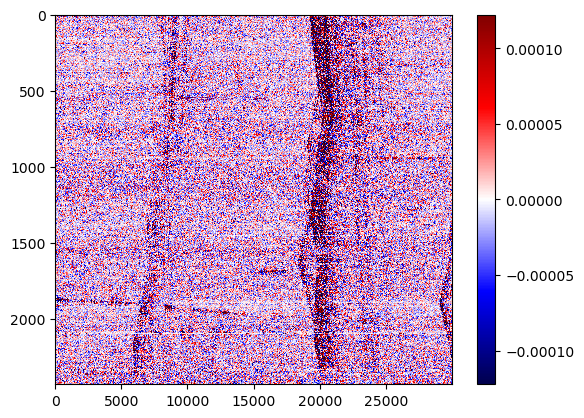

In [4]:
basicSeismicPlotter(data)
plt.show()